# Concept Bottleneck Model – Analysis

Use this after `tools/train_concept_classifier.py` finishes to inspect training dynamics and per-concept metrics.

Outputs assumed (adjust paths below):
- `outputs/concept_clip_probe_mimic_minfreq25/metrics.json`
- `outputs/concept_clip_probe_mimic_minfreq25/concept_index.json`
- `generated/concept_bank_sapbert_mimic/concept_schema.json`
- Optional: `generated/concept_bank_sapbert_mimic/study_concepts.jsonl` for frequency stats.

## Setup
Resolve paths and import dependencies for the analysis.


In [1]:
from pathlib import Path
import json
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

# Resolve repo root whether launched from repo/ or analysis/
CWD = Path.cwd()
if (CWD / "generated").exists():
    REPO_ROOT = CWD
elif (CWD.parent / "generated").exists():
    REPO_ROOT = CWD.parent
else:
    REPO_ROOT = CWD

RUN_DIR = REPO_ROOT / "outputs" / "concept_clip_probe_mimic_minfreq25"
CONCEPT_SCHEMA_PATH = REPO_ROOT / "generated" / "concept_bank_sapbert_mimic" / "concept_schema.json"
STUDY_CONCEPTS_PATH = REPO_ROOT / "generated" / "concept_bank_sapbert_mimic" / "study_concepts.jsonl"

print(f"Repo root: {REPO_ROOT}")
print(f"Run dir  : {RUN_DIR}")

Repo root: /home/obadah/code/MedCLIP
Run dir  : /home/obadah/code/MedCLIP/outputs/concept_clip_probe_mimic_minfreq25


## Figure defaults
Set high-resolution defaults for all plots.


In [ ]:
# Set a higher default DPI for all figures
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['savefig.dpi'] = 200


## Load run artifacts
Load metrics, concept index, and schema for analysis.


In [2]:
# Load metrics + concept metadata
metrics_path = RUN_DIR / "metrics.json"
concept_index_path = RUN_DIR / "concept_index.json"
if not metrics_path.exists():
    raise FileNotFoundError(f"metrics.json not found at {metrics_path}")
with metrics_path.open("r", encoding="utf-8") as handle:
    metrics_payload = json.load(handle)
history = metrics_payload.get("history", [])
per_class_metrics = metrics_payload.get("per_class_metrics")
tuned_thresholds = metrics_payload.get("tuned_thresholds")
with concept_index_path.open("r", encoding="utf-8") as handle:
    concept_index = json.load(handle)
concept_names = [concept_index[str(i)] for i in range(len(concept_index))]
schema = {}
if CONCEPT_SCHEMA_PATH.exists():
    schema = json.loads(CONCEPT_SCHEMA_PATH.read_text(encoding="utf-8"))
    print(f"Loaded concept schema with {len(schema):,} entries")
else:
    print("[warn] concept_schema.json not found – per-class table will miss curated labels.")
print(f"Loaded {len(history)} epochs of history")

Loaded concept schema with 6,163 entries
Loaded 25 epochs of history


## Training curves
Plot train/test loss and micro metrics across epochs.


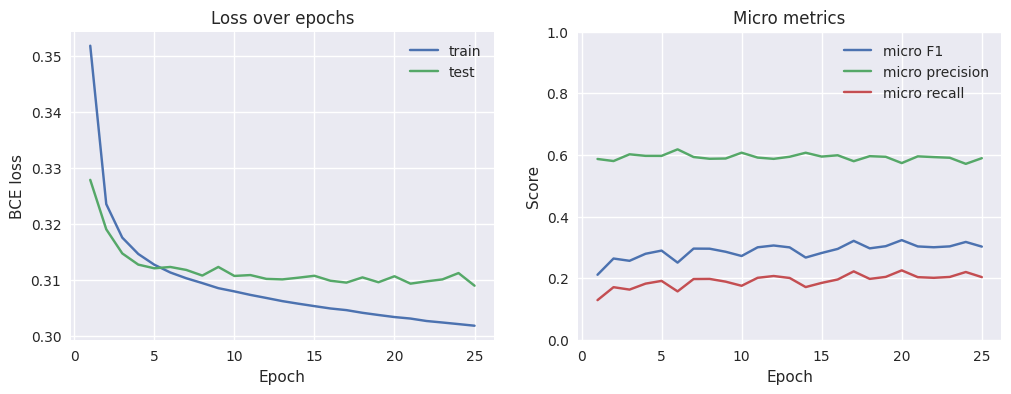

In [3]:
# Plot training vs. validation curves
if not history:
    raise ValueError("No training history found in metrics.json")
history_df = pd.DataFrame(history)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history_df["epoch"], history_df["train_loss"], label="train")
axes[0].plot(history_df["epoch"], history_df["test_loss"], label="test")
axes[0].set_title("Loss over epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("BCE loss")
axes[0].legend()

axes[1].plot(history_df["epoch"], history_df["micro_f1"], label="micro F1")
axes[1].plot(history_df["epoch"], history_df["micro_precision"], label="micro precision")
axes[1].plot(history_df["epoch"], history_df["micro_recall"], label="micro recall")
axes[1].set_title("Micro metrics")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Score")
axes[1].set_ylim(0, 1)
axes[1].legend()
plt.show()

## Per-concept metrics table
Assemble per-concept metrics, labels, and thresholds.


In [ ]:
# Build per-concept DataFrame
if per_class_metrics:
    per_class_df = pd.DataFrame(per_class_metrics)
    per_class_df = per_class_df.rename(columns={"class": "concept"})
    if tuned_thresholds:
        threshold_df = pd.DataFrame(tuned_thresholds).rename(columns={"class": "concept"})
        per_class_df = per_class_df.merge(
            threshold_df.rename(columns={"f1": "best_f1", "threshold": "best_threshold"}),
            on="concept",
            how="left",
        )
    labels = []
    semantic_types = []
    for name in per_class_df["concept"]:
        meta = schema.get(name, {})
        labels.append(meta.get("label", name))
        semantic_types.append(meta.get("semantic_type"))
    per_class_df["label"] = labels
    per_class_df["semantic_type"] = semantic_types
    per_class_df = per_class_df.sort_values("f1", ascending=False)
    per_class_df.head(10)
else:
    print("per_class_metrics missing - ensure train_concept_classifier.py was run with latest code.")

## Frequency vs F1
Scatter of concept frequency versus F1 to show the long tail.


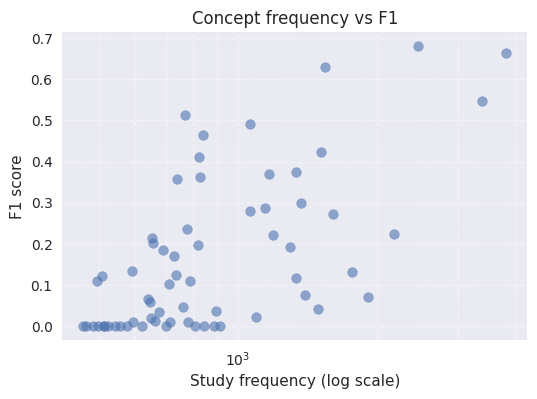

In [5]:
# Frequency vs. F1 scatter (requires study_concepts.jsonl)
if STUDY_CONCEPTS_PATH.exists() and 'per_class_df' in locals():
    counts = Counter()
    with STUDY_CONCEPTS_PATH.open("r", encoding="utf-8") as handle:
        for line in handle:
            record = json.loads(line)
            for item in record.get("concepts", []):
                if item.get("assertion") == "present":
                    counts[item.get("concept")] += 1
    freq_df = pd.DataFrame([{"concept": k, "frequency": v} for k, v in counts.items()])
    merged = per_class_df.merge(freq_df, on="concept", how="left")
    merged["frequency"] = merged["frequency"].fillna(0)
    plt.figure(figsize=(6, 4))
    plt.scatter(merged["frequency"], merged["f1"], alpha=0.6)
    plt.xscale("log")
    plt.xlabel("Study frequency (log scale)")
    plt.ylabel("F1 score")
    plt.title("Concept frequency vs F1")
    plt.grid(True, which="both", ls="--", alpha=0.4)
    plt.show()
else:
    print("Skipping frequency plot – either per-class metrics or study_concepts.jsonl missing.")

## Prediction dump (optional)
Run the trained head on cached features to save per-study predictions.


In [7]:
# Requires: RUN_DIR/best_model.pt and outputs/clip_feature_cache_mimic/{train.pt,test.pt}
import torch

checkpoint_path = RUN_DIR / "best_model.pt"
feature_cache_dir = REPO_ROOT / "outputs" / "clip_feature_cache_mimic"
train_cache_path = feature_cache_dir / "train.pt"
test_cache_path = feature_cache_dir / "test.pt"

if checkpoint_path.exists() and train_cache_path.exists():
    ckpt = torch.load(checkpoint_path, map_location="cpu", weights_only=False)
    state_dict = ckpt.get("model", ckpt)
    train_cache = torch.load(train_cache_path, map_location="cpu")
    feature_dim = train_cache["features"].shape[1]
    model = torch.nn.Linear(feature_dim, len(concept_names))
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    print(f"Loaded head: feature_dim={feature_dim}, num_concepts={len(concept_names)}")

    predictions_dir = RUN_DIR / "predictions"
    predictions_dir.mkdir(parents=True, exist_ok=True)

    def _run_split(cache_path: Path, split_name: str):
        cache = torch.load(cache_path, map_location="cpu")
        feats = cache["features"]
        study_ids = cache["study_ids"]
        with torch.no_grad():
            probs = torch.sigmoid(model(feats)).cpu()
        payload = {"study_ids": [str(s) for s in study_ids], "probs": probs}
        torch.save(payload, predictions_dir / f"{split_name}_probs.pt")
        jsonl_path = predictions_dir / f"{split_name}_probs.jsonl"
        with jsonl_path.open("w", encoding="utf-8") as handle:
            for sid, row in zip(payload["study_ids"], probs.tolist()):
                handle.write(json.dumps({"study_id": sid, "probs": row}) + "\n")
        print(f"[saved] {split_name} predictions -> {jsonl_path}")
        return payload

    _ = _run_split(train_cache_path, "train")
    if test_cache_path.exists():
        _ = _run_split(test_cache_path, "test")
    else:
        print(f"[warn] test cache not found: {test_cache_path}")
else:
    print("[skip] checkpoint or feature cache missing; skipping prediction dump.")

Loaded head: feature_dim=2048, num_concepts=64
[saved] train predictions -> /home/obadah/code/MedCLIP/outputs/concept_clip_probe_mimic_minfreq25/predictions/train_probs.jsonl
[saved] test predictions -> /home/obadah/code/MedCLIP/outputs/concept_clip_probe_mimic_minfreq25/predictions/test_probs.jsonl


## Qualitative inspection hooks

- Select a concept and list top-k studies with highest predicted probabilities (use predictions above).
- Visualize image thumbnails for TP/FP/FN cases (requires study_id → image_path mapping via dataset iterators).
- Plot concept–concept co-occurrence using `study_concepts.jsonl`.

Use helpers in `tools/train_concept_classifier.py` (`collect_study_predictions`, `build_sample_metadata`) if you want to extend this.

In [8]:
# Load saved predictions (train/test) if they exist
import pandas as pd

predictions_dir = RUN_DIR / 'predictions'
def _load_jsonl(path: Path) -> pd.DataFrame:
    rows = []
    with path.open('r', encoding='utf-8') as handle:
        for line in handle:
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

pred_train_path = predictions_dir / 'train_probs.jsonl'
pred_test_path = predictions_dir / 'test_probs.jsonl'
pred_df_list = []
if pred_train_path.exists():
    pred_df_list.append(_load_jsonl(pred_train_path))
if pred_test_path.exists():
    pred_df_list.append(_load_jsonl(pred_test_path))
if pred_df_list:
    preds_df = pd.concat(pred_df_list, ignore_index=True)
    print('Loaded predictions for %d studies' % len(preds_df))
else:
    preds_df = pd.DataFrame()
    print('[warn] No predictions found. Run the prediction dump cell above first.')


Loaded predictions for 10720 studies


In [9]:
# Select a concept and list top-k studies by predicted probability
TOP_K = 10
SELECTED_CONCEPT = 'Pleural effusion NOS (disorder)'  # change as needed

if not preds_df.empty:
    concept_to_idx = {name: i for i, name in enumerate(concept_names)}
    idx = concept_to_idx.get(SELECTED_CONCEPT)
    if idx is None:
        raise ValueError('Concept not found: %s' % SELECTED_CONCEPT)
    preds_df['prob'] = preds_df['probs'].map(lambda row: row[idx])
    top_df = preds_df.sort_values('prob', ascending=False).head(TOP_K)
    display(top_df[['study_id', 'prob']])
else:
    print('No predictions loaded; cannot compute top-k.')


,study_id,prob
9235,mimic_cxr:study53978179,0.994936
9676,mimic_cxr:study58471903,0.993765
9062,mimic_cxr:study50868481,0.991831
9353,mimic_cxr:study51358155,0.988712
10214,mimic_cxr:study56863436,0.988407
543,mimic_cxr:study50096675,0.986840
6560,mimic_cxr:study57241303,0.986068
8870,mimic_cxr:study53978179,0.985813
9623,mimic_cxr:study57007763,0.985512
2322,mimic_cxr:study52819519,0.985075


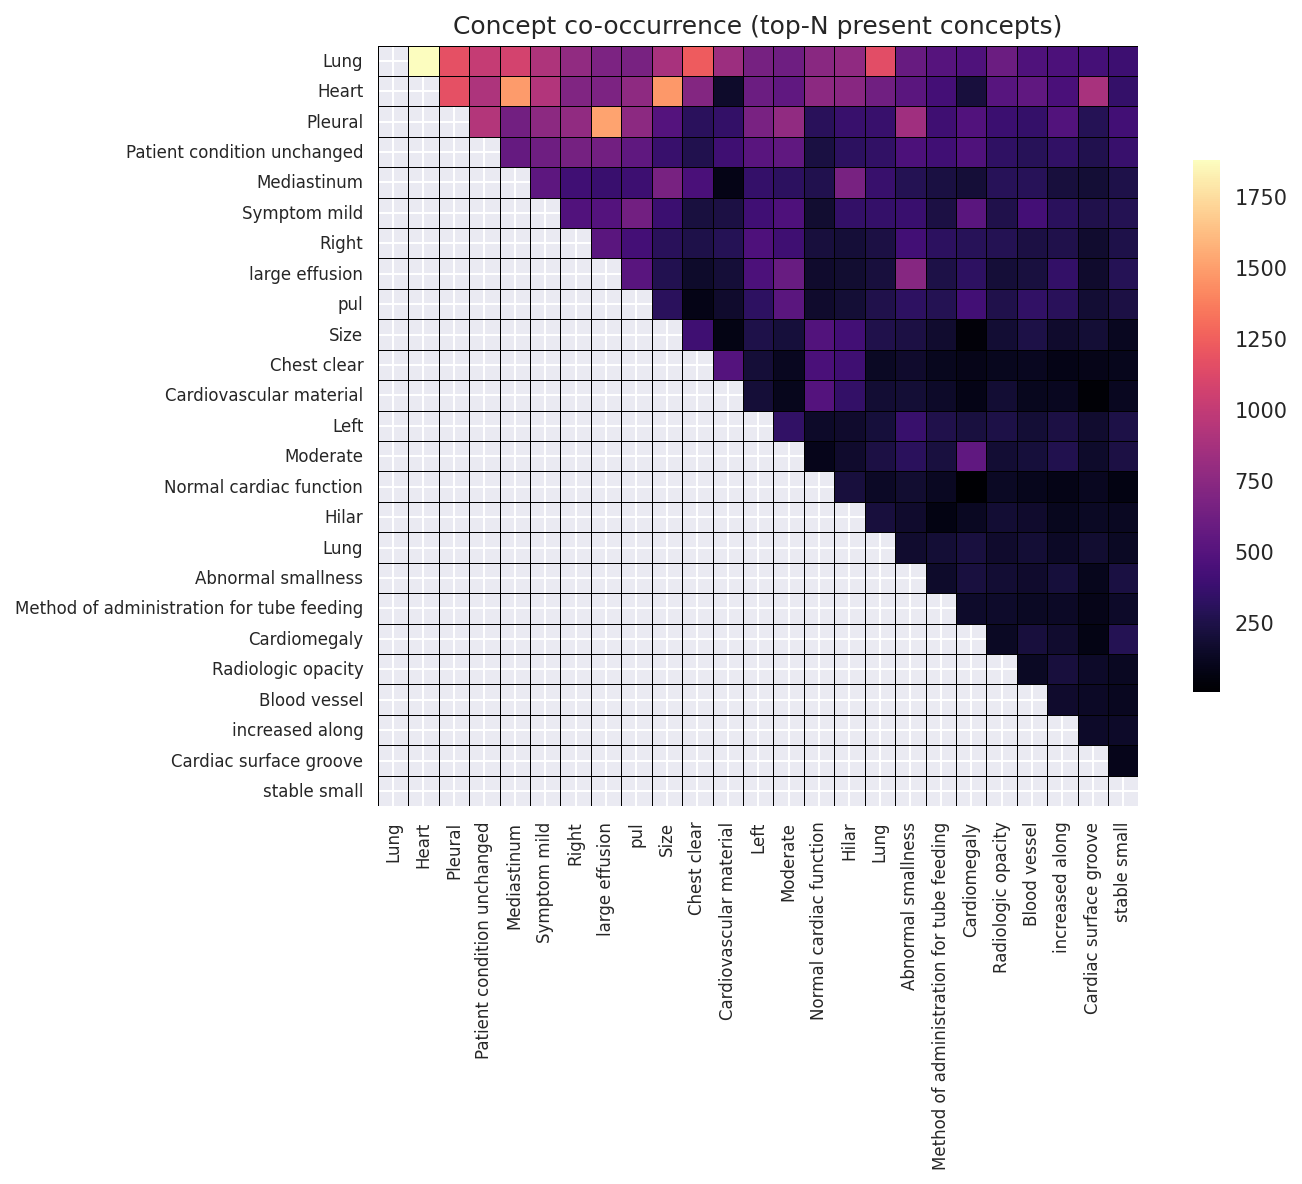

In [16]:
# Concept co-occurrence heatmap (present assertions, top-N frequent concepts; upper triangle only)
TOP_N = 25
if STUDY_CONCEPTS_PATH.exists():
    import seaborn as sns
    freq = Counter()
    cooc = Counter()
    with STUDY_CONCEPTS_PATH.open('r', encoding='utf-8') as handle:
        for line in handle:
            rec = json.loads(line)
            present = [c['concept'] for c in rec.get('concepts', []) if c.get('assertion') == 'present']
            unique = sorted(set(present))
            for c in unique:
                freq[c] += 1
            for i, a in enumerate(unique):
                for b in unique[i+1:]:
                    cooc[(a, b)] += 1
                    cooc[(b, a)] += 1
    top_concepts = [c for c, _ in freq.most_common(TOP_N)]
    idx_map = {c: i for i, c in enumerate(top_concepts)}
    mat = np.zeros((TOP_N, TOP_N), dtype=float)
    for (a, b), v in cooc.items():
        i = idx_map.get(a)
        j = idx_map.get(b)
        if i is not None and j is not None:
            mat[i, j] = v
    for i in range(TOP_N):
        mat[i, i] = 0
    labels = [schema.get(c, {}).get('label', c) for c in top_concepts]
    mask = np.tril(np.ones_like(mat, dtype=bool))  # mask diagonal and lower triangle
    plt.figure(figsize=(10, 8), dpi=200)
    ax = sns.heatmap(mat, mask=mask, cmap='magma', square=True, linewidths=0.4, linecolor='black',
                     xticklabels=labels, yticklabels=labels, cbar_kws={'shrink': 0.7})
    ax.set_xticklabels(labels, rotation=90, fontsize=8)
    ax.set_yticklabels(labels, rotation=0, fontsize=8)
    ax.set_title('Concept co-occurrence (top-N present concepts)', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print('study_concepts.jsonl not found; skipping co-occurrence heatmap.')


## Per-concept calibration
Reliability curves + ECE/Brier for the top concepts to spot over/under-confidence.


,concept,ece,brier
1,Lung part,0.009160,0.227556
7,PUL (body structure),0.012523,0.121556
9,Cardiovascular material,0.014553,0.143961
4,Structure of carina,0.014622,0.040410
8,Structure of right pleural cavity,0.016672,0.072469
5,Method of administration for tube feeding,0.016747,0.064477
6,Stomach structure,0.017610,0.056604
3,"Heart, NOS",0.021980,0.235857
0,Pleural,0.039226,0.144163
2,Pleural effusion NOS (disorder),0.053069,0.103777


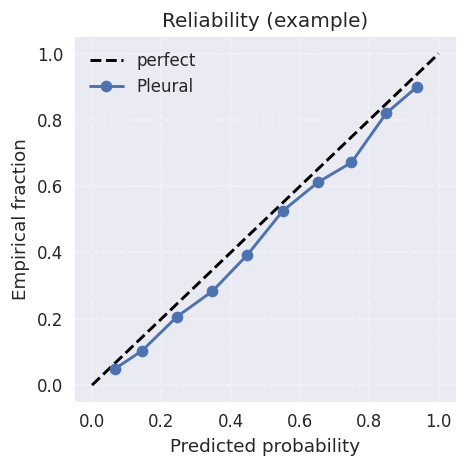

In [22]:
# Per-concept calibration: reliability curves + ECE for top-N concepts
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

CALIB_TOP_N = 10
if 'per_class_df' in locals() and not preds_df.empty:
    gt_map = {}  # study_id -> set of present concepts
    if STUDY_CONCEPTS_PATH.exists():
        with STUDY_CONCEPTS_PATH.open('r', encoding='utf-8') as handle:
            for line in handle:
                rec = json.loads(line)
                sid = str(rec.get('study_id') or rec.get('record_id') or rec.get('study_key', ''))
                present = [c['concept'] for c in rec.get('concepts', []) if c.get('assertion') == 'present']
                if sid:
                    gt_map[sid] = set(present)
    top_concepts = per_class_df.head(CALIB_TOP_N)['concept'].tolist()
    concept_to_idx = {name: i for i, name in enumerate(concept_names)}
    rows = []
    bin_edges = np.linspace(0, 1, 11)
    for concept in top_concepts:
        idx_c = concept_to_idx.get(concept)
        if idx_c is None:
            continue
        y_pred = []
        y_true = []
        for sid, probs in zip(preds_df['study_id'], preds_df['probs']):
            if sid not in gt_map:
                continue
            y_pred.append(probs[idx_c])
            y_true.append(1.0 if concept in gt_map[sid] else 0.0)
        if not y_pred:
            continue
        prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10, strategy='uniform')
        y_pred_arr = np.array(y_pred)
        y_true_arr = np.array(y_true)
        total = len(y_pred_arr)
        ece = 0.0
        for i_bin in range(len(bin_edges) - 1):
            lo, hi = bin_edges[i_bin], bin_edges[i_bin + 1]
            if i_bin < len(bin_edges) - 2:
                mask = (y_pred_arr >= lo) & (y_pred_arr < hi)
            else:
                mask = (y_pred_arr >= lo) & (y_pred_arr <= hi)
            count = mask.sum()
            if count == 0:
                continue
            acc = (y_true_arr[mask]).mean()
            conf = (y_pred_arr[mask]).mean()
            ece += abs(acc - conf) * count / total
        brier = brier_score_loss(y_true, y_pred)
        rows.append({'concept': concept, 'ece': ece, 'brier': brier, 'prob_true': prob_true, 'prob_pred': prob_pred})
    if rows:
        calib_df = pd.DataFrame(rows).sort_values('ece')
        display(calib_df[['concept', 'ece', 'brier']])
        first = rows[0]
        plt.figure(figsize=(4, 4), dpi=200)
        plt.plot([0, 1], [0, 1], 'k--', label='perfect')
        plt.plot(first['prob_pred'], first['prob_true'], marker='o', label=first['concept'])
        plt.xlabel('Predicted probability')
        plt.ylabel('Empirical fraction')
        plt.title('Reliability (example)')
        plt.legend()
        plt.grid(True, ls='--', alpha=0.4)
        plt.tight_layout()
    else:
        print('No overlapping predictions/ground truth to compute calibration.')
else:
    print('Need per_class_df and preds_df to compute calibration.')


## Precision–Recall curves
PR curves and AP for the most frequent concepts; helps pick thresholds.


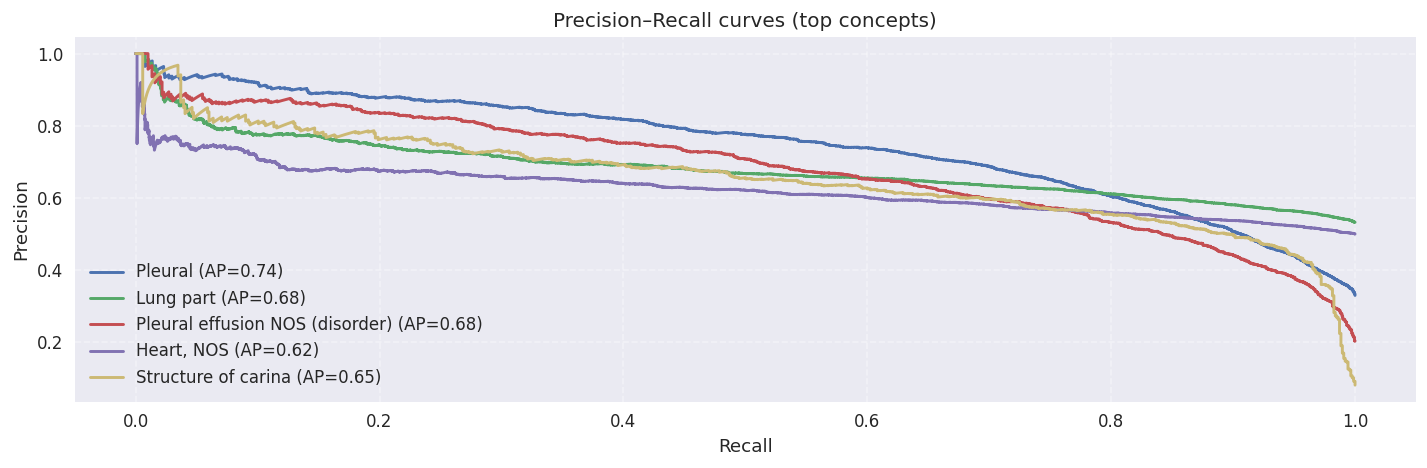

In [18]:
# Precision-recall curves for top-N concepts
from sklearn.metrics import precision_recall_curve, average_precision_score
PR_TOP_N = 5
if 'per_class_df' in locals() and not preds_df.empty and STUDY_CONCEPTS_PATH.exists():
    concept_to_idx = {name: i for i, name in enumerate(concept_names)}
    gt_map = {}
    with STUDY_CONCEPTS_PATH.open('r', encoding='utf-8') as handle:
        for line in handle:
            rec = json.loads(line)
            sid = str(rec.get('study_id') or rec.get('record_id') or rec.get('study_key', ''))
            present = {c['concept'] for c in rec.get('concepts', []) if c.get('assertion') == 'present'}
            if sid:
                gt_map[sid] = present
    top_concepts = per_class_df.head(PR_TOP_N)['concept'].tolist()
    plt.figure(figsize=(12, 4), dpi=200)
    for concept in top_concepts:
        idx = concept_to_idx.get(concept)
        if idx is None:
            continue
        y_scores = []
        y_true = []
        for sid, probs in zip(preds_df['study_id'], preds_df['probs']):
            if sid not in gt_map:
                continue
            y_scores.append(probs[idx])
            y_true.append(1.0 if concept in gt_map[sid] else 0.0)
        if not y_scores:
            continue
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        ap = average_precision_score(y_true, y_scores)
        plt.plot(recall, precision, label='%s (AP=%.2f)' % (concept, ap))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision–Recall curves (top concepts)')
    plt.legend()
    plt.grid(True, ls='--', alpha=0.4)
    plt.tight_layout()
else:
    print('Need predictions and study_concepts.jsonl to plot PR curves.')


## Error breakdown
FP/FN counts for top concepts to see dominant error modes.


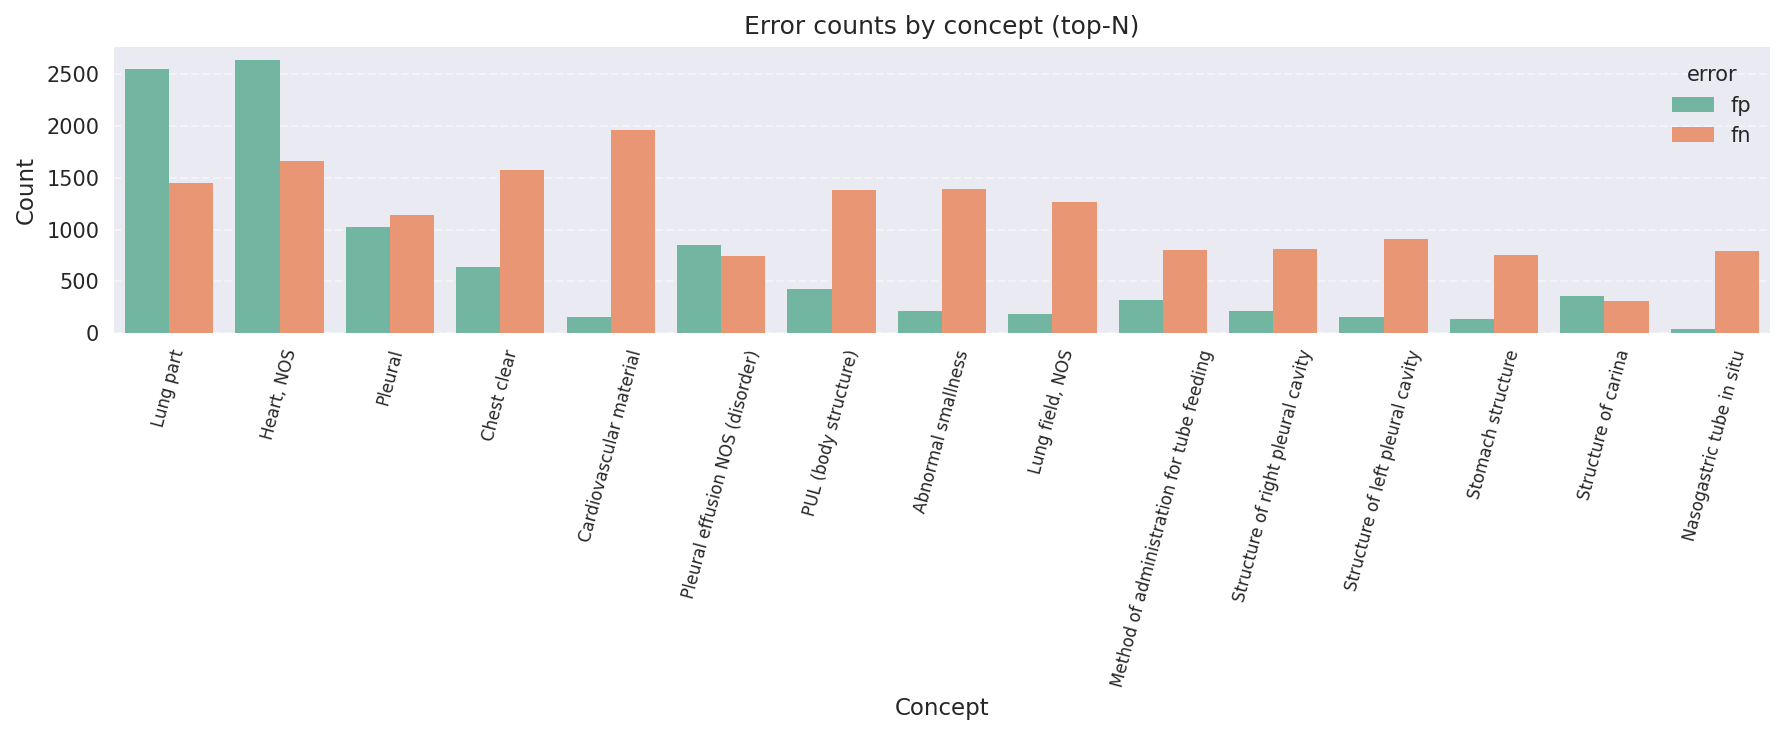

In [23]:
# Frequency vs error type (FP vs FN counts) for top-N concepts
ERR_TOP_N = 15
if 'per_class_df' in locals() and not preds_df.empty and STUDY_CONCEPTS_PATH.exists():
    concept_to_idx = {name: i for i, name in enumerate(concept_names)}
    gt_map = {}
    with STUDY_CONCEPTS_PATH.open('r', encoding='utf-8') as handle:
        for line in handle:
            rec = json.loads(line)
            sid = str(rec.get('study_id') or rec.get('record_id') or rec.get('study_key', ''))
            present = {c['concept'] for c in rec.get('concepts', []) if c.get('assertion') == 'present'}
            if sid:
                gt_map[sid] = present
    rows = []
    for concept in per_class_df.head(ERR_TOP_N)['concept']:
        idx_c = concept_to_idx.get(concept)
        if idx_c is None:
            continue
        fp = fn = tp = tn = 0
        for sid, probs in zip(preds_df['study_id'], preds_df['probs']):
            if sid not in gt_map:
                continue
            pred = probs[idx_c] >= 0.5
            truth = concept in gt_map[sid]
            if pred and truth:
                tp += 1
            elif pred and not truth:
                fp += 1
            elif (not pred) and truth:
                fn += 1
            else:
                tn += 1
        rows.append({'concept': concept, 'fp': fp, 'fn': fn, 'tp': tp, 'tn': tn})
    err_df = pd.DataFrame(rows)
    err_df['freq_gt'] = err_df['tp'] + err_df['fn']
    err_df = err_df.sort_values('freq_gt', ascending=False)
    err_df_plot = err_df.melt(id_vars=['concept'], value_vars=['fp', 'fn'], var_name='error', value_name='count')
    plt.figure(figsize=(12, 5), dpi=200)
    ax = sns.barplot(data=err_df_plot, x='concept', y='count', hue='error', palette='Set2')
    ax.set_title('Error counts by concept (top-N)', fontsize=12)
    ax.set_xlabel('Concept')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=75, labelsize=8)
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
else:
    print('Need predictions and ground truth to compute error breakdown.')


## Semantic-type metrics
Average precision/recall/F1 grouped by semantic_type.


,precision,recall,f1
semantic_type,,,
BodyStructure,0.408841,0.149542,0.19203
Finding,0.398538,0.101413,0.13639


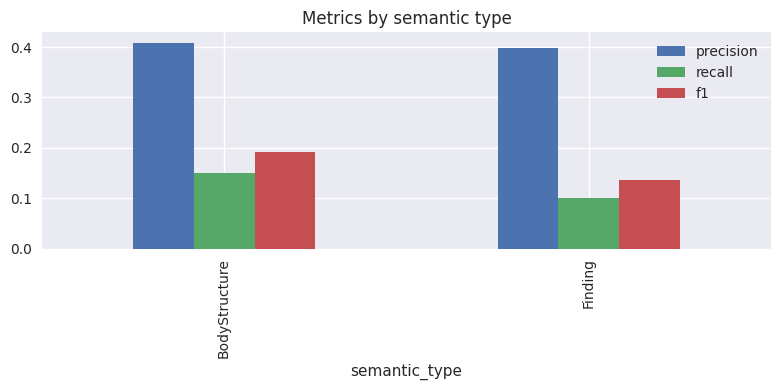

In [20]:
# Semantic-type breakdown of metrics
if 'per_class_df' in locals() and 'semantic_type' in per_class_df.columns:
    agg = per_class_df.groupby('semantic_type')[['precision','recall','f1']].mean().sort_values('f1', ascending=False)
    display(agg)
    agg.plot(kind='bar', figsize=(8, 4), title='Metrics by semantic type')
    plt.tight_layout()
else:
    print('Semantic types not available in per_class_df.')


## Label cleaning hints
Find concepts with decent AP but low F1 (merge/tune candidates).


In [25]:
LABEL_HINT_TOP = 20
if 'per_class_df' in locals():
    df = per_class_df.copy()
    df['f1_used'] = df['best_f1'] if 'best_f1' in df.columns else df['f1']
    df['ap'] = df['ap'] if 'ap' in df.columns else df['f1_used']
    df['gap'] = df['ap'] - df['f1_used']
    hints = df.sort_values('gap', ascending=False).head(LABEL_HINT_TOP)[['concept','label','ap','f1_used','gap','semantic_type']]
    display(hints)
else:
    print('per_class_df missing; run earlier cells first.')


,concept,label,ap,f1_used,gap,semantic_type
2,Pleural,Pleural,0.690589,0.690589,0.0,BodyStructure
0,Lung part,Lung,0.704142,0.704142,0.0,BodyStructure
7,Pleural effusion NOS (disorder),large effusion,0.637744,0.637744,0.0,Finding
1,"Heart, NOS",Heart,0.655566,0.655566,0.0,BodyStructure
33,Structure of carina,Structure of carina,0.644860,0.644860,0.0,BodyStructure
19,Method of administration for tube feeding,Method of administration for tube feeding,0.633803,0.633803,0.0,Finding
25,Stomach structure,Stomach,0.566038,0.566038,0.0,BodyStructure
8,PUL (body structure),pul,0.552908,0.552908,0.0,BodyStructure
27,Structure of right pleural cavity,Structure of right pleural cavity,0.536000,0.536000,0.0,BodyStructure
13,Cardiovascular material,Cardiovascular material,0.499029,0.499029,0.0,BodyStructure


## Concept similarity clusters
Correlation-based clustering of concept predictions (top-N).


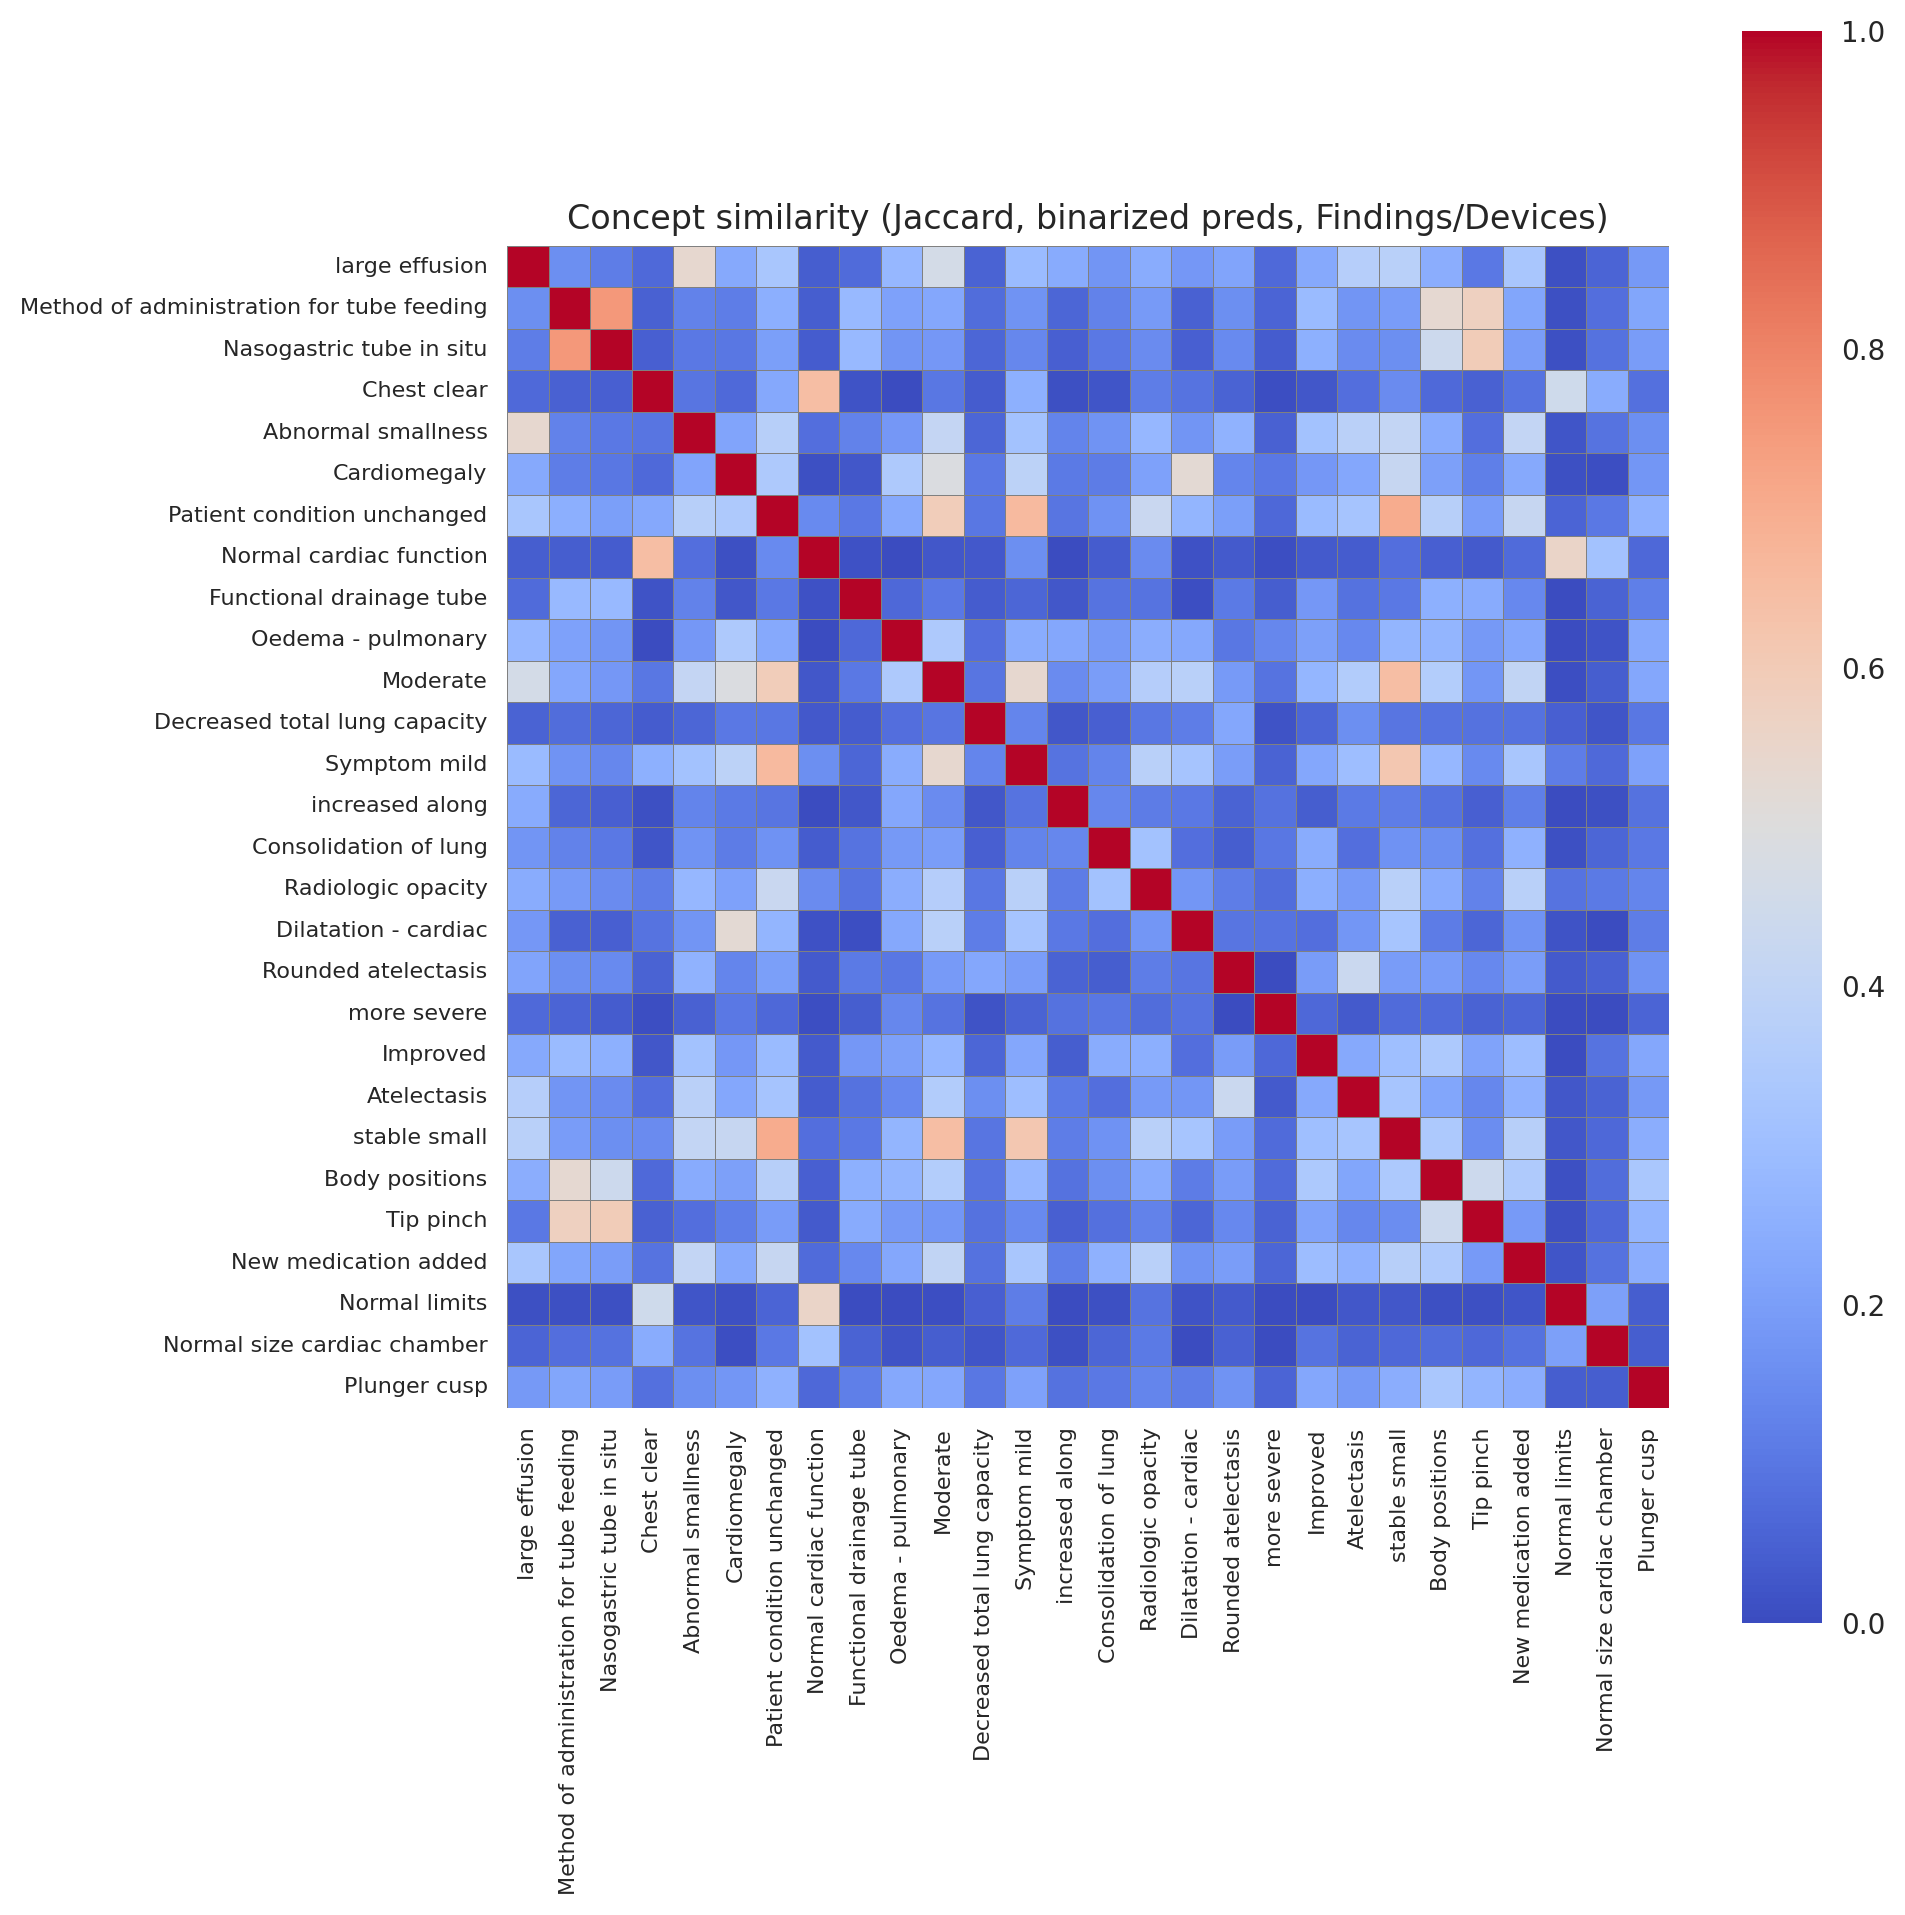

In [35]:
# Concept similarity clusters (Jaccard on binarized preds; Findings/Devices only)
SIM_TOP_N = 30  # top frequent concepts to consider
ALLOWED_TYPES = {'Finding', 'Device'}
MIN_PRED_POS = 25  # require at least this many predicted positives to include a concept
if not preds_df.empty and 'semantic_type' in per_class_df.columns:
    concept_to_idx = {name: i for i, name in enumerate(concept_names)}
    # thresholds: use tuned best_threshold if available, else 0.5
    thresh_map = {}
    if 'best_threshold' in per_class_df.columns:
        thresh_map = dict(zip(per_class_df['concept'], per_class_df['best_threshold'].fillna(0.5)))
    filtered = per_class_df[per_class_df['semantic_type'].isin(ALLOWED_TYPES)]
    top_concepts = filtered.head(SIM_TOP_N)['concept'].tolist()
    cols = []
    for c in top_concepts:
        idx_c = concept_to_idx.get(c)
        if idx_c is not None:
            cols.append((c, idx_c))
    if not cols:
        print('No concepts found for clustering (check ALLOWED_TYPES or data).')
    else:
        # Build binarized matrix with concept-specific thresholds
        mat = []
        for probs in preds_df['probs']:
            row = []
            for c, idx_c in cols:
                thr = thresh_map.get(c, 0.5)
                row.append(1.0 if probs[idx_c] >= thr else 0.0)
            mat.append(row)
        mat = np.array(mat)
        # Filter out concepts with too few positives
        keep = (mat.sum(axis=0) >= MIN_PRED_POS)
        if not keep.any():
            print('No concepts passed MIN_PRED_POS; lower threshold or MIN_PRED_POS.')
        else:
            mat = mat[:, keep]
            kept_cols = [cols[i] for i, k in enumerate(keep) if k]
            labels = [schema.get(c, {}).get('label', c) for c, _ in kept_cols]
            n = mat.shape[1]
            sims = np.zeros((n, n))
            for i in range(n):
                ai = mat[:, i]
                for j in range(i, n):
                    aj = mat[:, j]
                    inter = np.logical_and(ai, aj).sum()
                    union = np.logical_or(ai, aj).sum()
                    sims[i, j] = sims[j, i] = inter / union if union else 0.0
            plt.figure(figsize=(10, 10), dpi=200)
            sns.heatmap(
                sims,
                cmap='coolwarm',
                xticklabels=labels,
                yticklabels=labels,
                square=True,
                linewidths=0.25,
                linecolor='gray',
            )
            plt.xticks(rotation=90, fontsize=8)
            plt.yticks(rotation=0, fontsize=8)
            plt.title('Concept similarity (Jaccard, binarized preds, Findings/Devices)')
            plt.tight_layout()
            plt.show()

else:
    print('preds_df empty or semantic_type missing; run earlier cells first.')


## Coverage summary
Compare prediction and ground-truth coverage; density overview.


Pred studies: 7,007 | GT studies: 7,071 | Overlap: 7,007


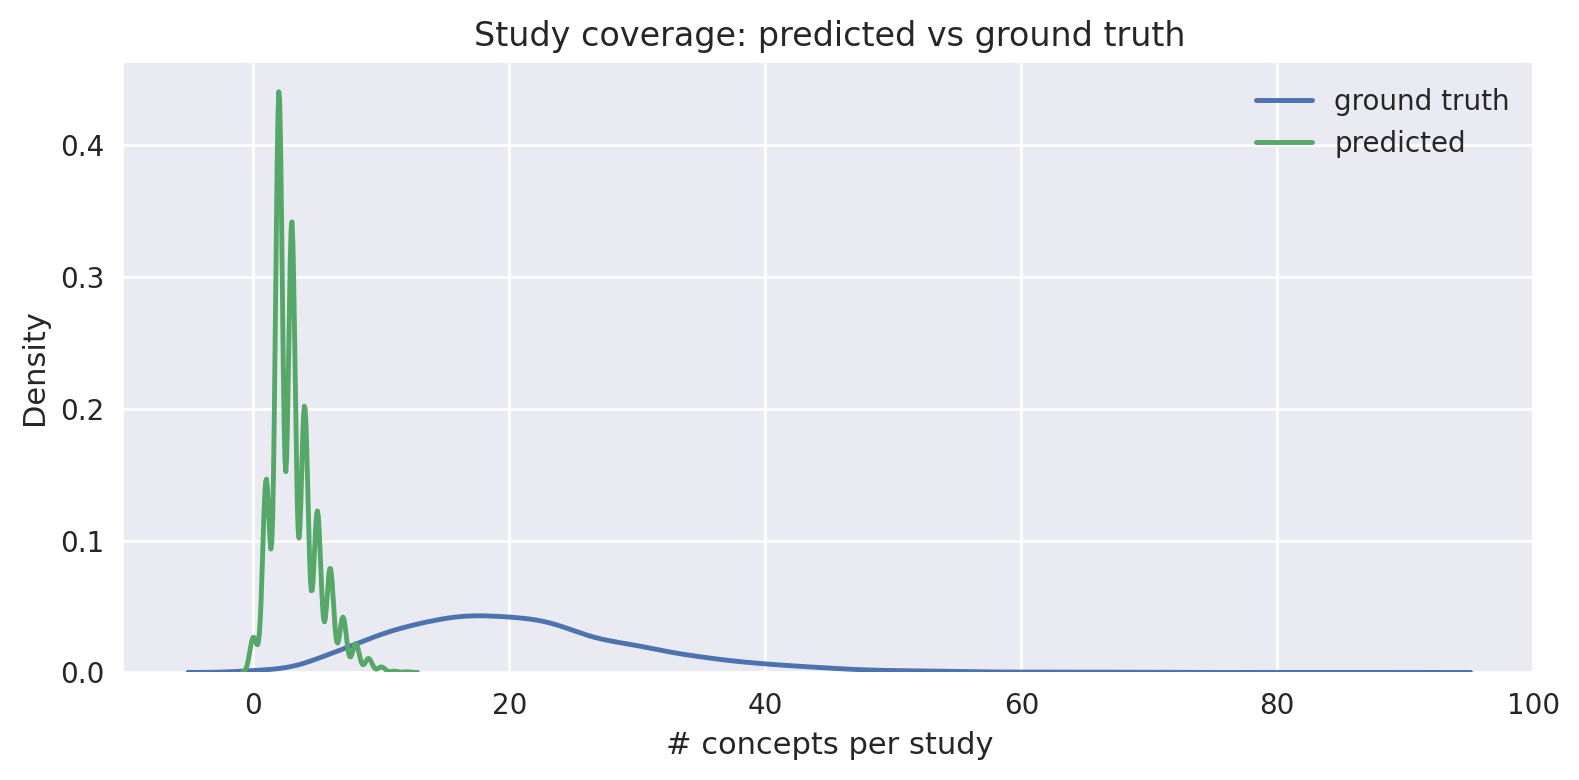

In [34]:
if not preds_df.empty and STUDY_CONCEPTS_PATH.exists():
    preds_studies = set(map(str, preds_df['study_id']))
    gt_studies = set()
    gt_counts = []
    with STUDY_CONCEPTS_PATH.open('r', encoding='utf-8') as handle:
        for line in handle:
            rec = json.loads(line)
            sid = str(rec.get('study_id') or rec.get('record_id') or rec.get('study_key', ''))
            present = [c for c in rec.get('concepts', []) if c.get('assertion') == 'present']
            if sid:
                gt_studies.add(sid)
                gt_counts.append(len(present))
    inter = preds_studies & gt_studies
    print(f'Pred studies: {len(preds_studies):,} | GT studies: {len(gt_studies):,} | Overlap: {len(inter):,}')
    pred_counts = preds_df['probs'].map(lambda row: sum(1 for v in row if v >= 0.5)).tolist()
    plt.figure(figsize=(8,4), dpi=200)
    sns.kdeplot(gt_counts, label='ground truth')
    sns.kdeplot(pred_counts, label='predicted')
    plt.xlabel('# concepts per study')
    plt.title('Study coverage: predicted vs ground truth')
    plt.legend()
    plt.tight_layout()
else:
    print('Need preds_df and study_concepts.jsonl for coverage summary.')


## CBM label-head analysis
Load CBM label-head metrics (outputs/cbm_label_head) and plot training curves.


In [ ]:
CBM_RUN_DIR = REPO_ROOT / 'outputs' / 'cbm_label_head'
CBM_METRICS_PATH = CBM_RUN_DIR / 'cbm_metrics.json'
cbm_history = None
cbm_metrics = None
if CBM_METRICS_PATH.exists():
    with CBM_METRICS_PATH.open('r', encoding='utf-8') as handle:
        cbm_metrics = json.load(handle)
    cbm_history = cbm_metrics.get('history', [])
    print('Loaded CBM metrics from %s' % CBM_METRICS_PATH)
    print('Best micro_f1: %s | train_samples=%s test_samples=%s' % (cbm_metrics.get('best_micro_f1'), cbm_metrics.get('train_samples'), cbm_metrics.get('test_samples')))
else:
    print('[warn] CBM metrics not found at %s' % CBM_METRICS_PATH)


Loaded CBM metrics from /home/obadah/code/MedCLIP/outputs/cbm_label_head/cbm_metrics.json
Best micro_f1: 0.46511627446187137 | train_samples=5969 test_samples=42


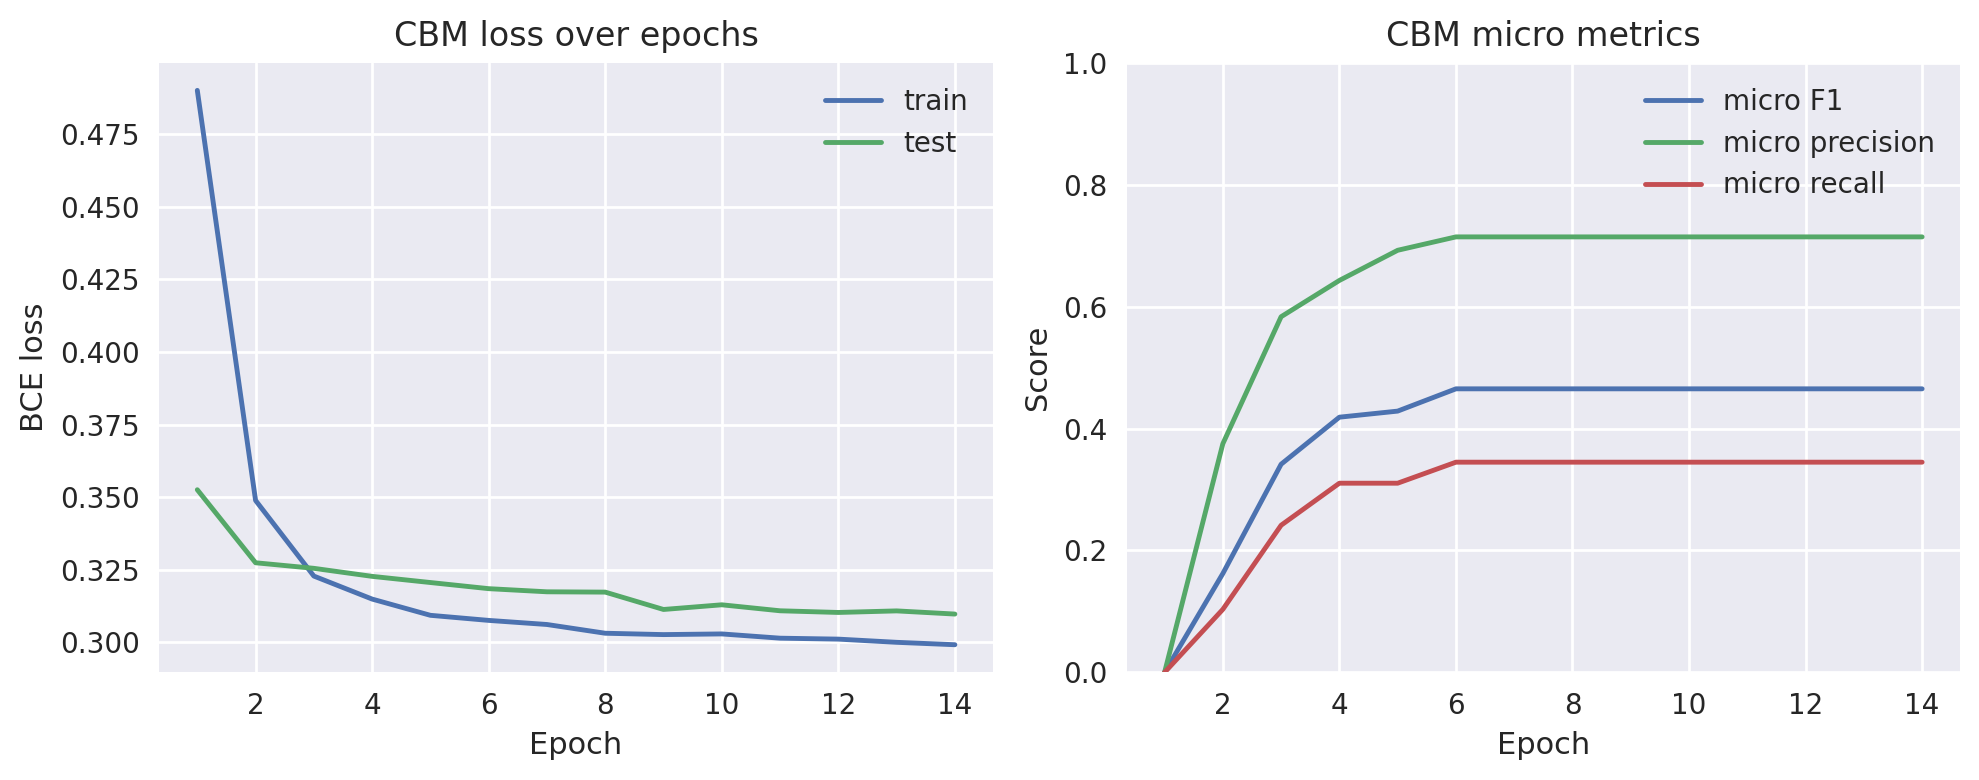

In [37]:
# CBM training curves
if cbm_history:
    cbm_df = pd.DataFrame(cbm_history)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=200)
    axes[0].plot(cbm_df['epoch'], cbm_df['train_loss'], label='train')
    axes[0].plot(cbm_df['epoch'], cbm_df['test_loss'], label='test')
    axes[0].set_title('CBM loss over epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('BCE loss')
    axes[0].legend()
    axes[1].plot(cbm_df['epoch'], cbm_df['micro_f1'], label='micro F1')
    if 'micro_precision' in cbm_df.columns:
        axes[1].plot(cbm_df['epoch'], cbm_df['micro_precision'], label='micro precision')
    if 'micro_recall' in cbm_df.columns:
        axes[1].plot(cbm_df['epoch'], cbm_df['micro_recall'], label='micro recall')
    axes[1].set_title('CBM micro metrics')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Score')
    axes[1].set_ylim(0, 1)
    axes[1].legend()
    plt.tight_layout()
else:
    print('CBM history missing; ensure cbm_metrics.json is available.')


In [38]:
# CBM metric summary table
if cbm_metrics:
    summary_keys = ['best_micro_f1','micro_auroc','micro_auprc','macro_auroc','macro_auprc','label_density']
    summary = {k: cbm_metrics.get(k) for k in summary_keys if k in cbm_metrics}
    display(pd.DataFrame([summary]))
else:
    print('No CBM metrics loaded.')


,best_micro_f1
0,0.465116
